# Install et import

In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import os
import pickle

data = pd.read_csv("/Users/kraligan/Blent_module3_project/data/Churn_Modelling.csv").set_index('CustomerId')

# Analyse
Dans cette première étape, on cherche à explorer le jeu de données et à étudier les propriétés statistiques des variables pour détecter les valeurs aberrantes ou manquantes, et obtenir plus de visibilité sur le périmètre des données.

Les graphiques de Data Visualization vont permettre d'apporter plus d'indications sur la typologie des variables en utilisant des boîtes à moustaches ou des histogrammes.


In [74]:
data.head()

,RowNumber,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,,,,
15634602,1,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
15647311,2,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
15619304,3,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
15701354,4,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
15737888,5,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<Axes: >

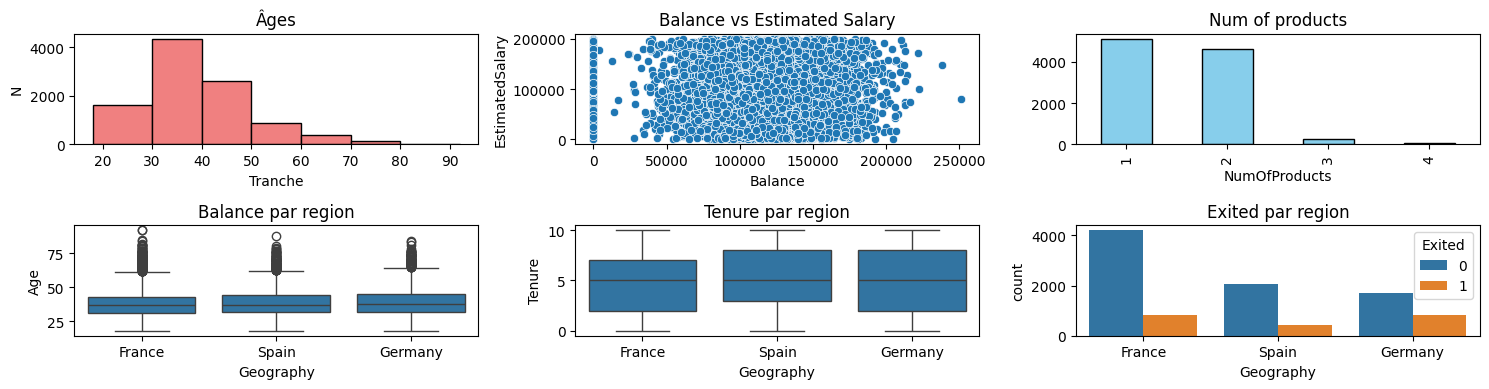

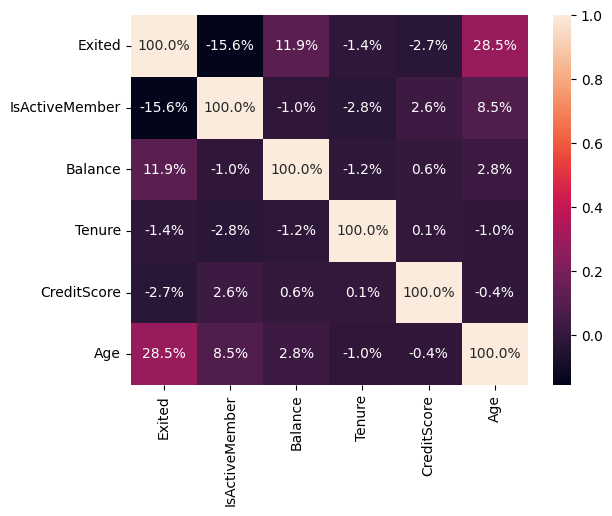

In [ ]:
# statisques: 
## Age 18 -> 92 (moyenne: 38.9)
## number of exited 0 -> 7963, 1 -> 2037
## Tenure: 0 -> 10 (moyenne 5)
## Gender : F=4543 , M=5457
## HasCrCard 1 -> 7055 0 -> 2945
## CreditScore 350 -> 850 (moyenne: 650)

fig, axs = plt.subplots(2, 3, figsize=(15, 4))  # 1 ligne, 3 colonnes

## plot histo age: (utile?)
bins = [18, 30, 40, 50, 60, 70, 80, 92]
axs[0,0].hist(data.Age, bins=bins, edgecolor='black', color='lightcoral')
axs[0,0].set_title("Âges")
axs[0,0].set_xlabel("Tranche")
axs[0,0].set_ylabel("N")

## plot balance et estimated salary
sns.scatterplot(data=data, x='Balance', y='EstimatedSalary', ax=axs[0,1])
axs[0,1].set_title("Balance vs Estimated Salary")

## plot histo num of products
data.NumOfProducts.value_counts().plot(kind='bar', ax=axs[0,2], color='skyblue', edgecolor='black')
axs[0,2].set_title("Num of products")

## L2: Boite moustache geographie -> lien avec NumOfProducts, Tenure, Age, Exited?
sns.boxplot(data, x='Geography', y='Age', ax=axs[1,0])
axs[1,0].set_title("Balance par region")
sns.boxplot(data, x='Geography', y='Tenure', ax=axs[1,1])
axs[1,1].set_title("Tenure par region")
sns.countplot(data=data, x='Geography', hue='Exited', ax=axs[1,2])
axs[1,2].set_title("Exited par region")
# La geography semble avoir peut d'incidence -> peu utile a encoder et garder je suppose? Quoi que... encodons
plt.tight_layout()

## Exit -> lien avec age, IsActiveMember, Balance, Tenure, CreditScore (heatmap)?
plt.figure()
correlation = data[['Exited', 'IsActiveMember', 'Balance', 'Tenure', 'CreditScore', 'Age']].corr()
sns.heatmap(correlation,fmt=".1%", annot=True)
# L'age semble etre la principale raison?




# Nettoyage
Les valeurs manquantes doivent être imputées ou retirer pour pouvoir calibrer un modèle de Machine Learning. De plus, certaines variables sont qualitatives : il faut donc utiliser des méthodes d'encodage numérique pour obtenir une base d'apprentissage purement quantitative.

In [88]:
# Valeur manquantes: 0
print("Valeurs manquantes: ", data.isna().any())

# On supprime les colonnes inutiles : RowNumber, Surname, Geography, Gender
data = data.drop(['RowNumber', 'Surname'], axis=1)

# Encodage de Geography (OneHot)
data = pd.get_dummies(data, columns=['Geography'])

# Encodage de Gender
data['Gender'] = data['Gender'].map({'Female': 0, 'Male': 1})
data.head()


Valeurs manquantes:  RowNumber          False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
CustomerId,,,,,,,,,,,,,
15634602,619,0,42,2,0.00,1,1,1,101348.88,1,True,False,False
15647311,608,0,41,1,83807.86,1,0,1,112542.58,0,False,False,True
15619304,502,0,42,8,159660.80,3,1,0,113931.57,1,True,False,False
15701354,699,0,39,1,0.00,2,0,0,93826.63,0,True,False,False
15737888,850,0,43,2,125510.82,1,1,1,79084.10,0,False,False,True


In [89]:
data.head()
data.to_csv("/Users/kraligan/Blent_module3_project/data/dataset.csv")

# Entrainement ML
En essayant plusieurs modèles de Machine Learning candidats, il faut sélectionner celui qui maximise les performances (en se basant sur différentes métriques). Le modèle retenu doit être optimisé au niveau des hyper-paramètres pour satisfaire la contrainte de performance annoncée.

In [106]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
dataset = pd.read_csv("/Users/kraligan/Blent_module3_project/data/dataset.csv").set_index('CustomerId')
dataset.head()

X = dataset.drop(['Exited'], axis=1)
y = dataset['Exited'].astype(bool)

# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=24)
# -> Si je fais de la Cross validation, cela est inutile non??

In [ ]:
from sklearn.model_selection import GridSearchCV
import pickle

param_grid = {
    "max_depth": [5, 10, 20],
    "n_estimators": [20, 50, 100],
}

grid_cv_Forest = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    scoring="roc_auc",
    cv=10,
)



grid_cv_Forest.fit(X,y)

# Enregistrement du meilleur modèle trouvé par GridSearchCV
with open("best_random_forest.pkl", "wb") as f:
    pickle.dump(grid_cv_Forest.best_estimator_, f)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 20],
                         'n_estimators': [20, 50, 100]},
             scoring='roc_auc')

# Evaluation
Une fois le modèle obtenu, une méthode de validation croisée (type kk-Fold) doit être utilisée pour vérifier la stabilité du modèle par rapport aux données d'apprentissage. Le résultat fournit doit permettre de vérifier les contraintes du projet.

Meilleur score AUC : 0.8606761190423624
Meilleurs paramètres : {'max_depth': 10, 'n_estimators': 50}
Ecart type : 0.010281709994124326


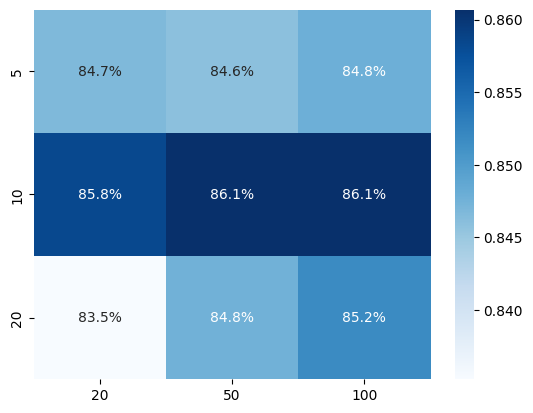

In [ ]:


score_matrix = np.asarray(grid_cv_Forest.cv_results_["mean_test_score"]).reshape((3, 3))
sns.heatmap(
    score_matrix,  # Matrice des scores
    annot=True,  # Afficher les scores
    fmt='.01%',  # Affichage en pourcentage avec 1 chiffre après la virgule
    yticklabels=param_grid["max_depth"],  # Nom de l'axe vertical
    xticklabels=param_grid["n_estimators"],  # Nom de l'axe horizontal
    cmap="Blues"  # Palette de couleur
)

print("Meilleur score AUC :", grid_cv_Forest.best_score_)
print("Meilleurs paramètres :", grid_cv_Forest.best_params_)
print("Ecart type :", grid_cv_Forest.cv_results_['std_test_score'][grid_cv_Forest.best_index_])
# 86% le model est OKAY avec les param n_estimator = 50 et max_depth=10

# Interpretation

In [ ]:
import pickle
import shap

with open("best_random_forest.pkl", "rb") as f:
    best_model = pickle.load(f)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

X shape : (10000, 12)
shap_values[1] shape : (500, 12, 2)


<Figure size 640x480 with 0 Axes>

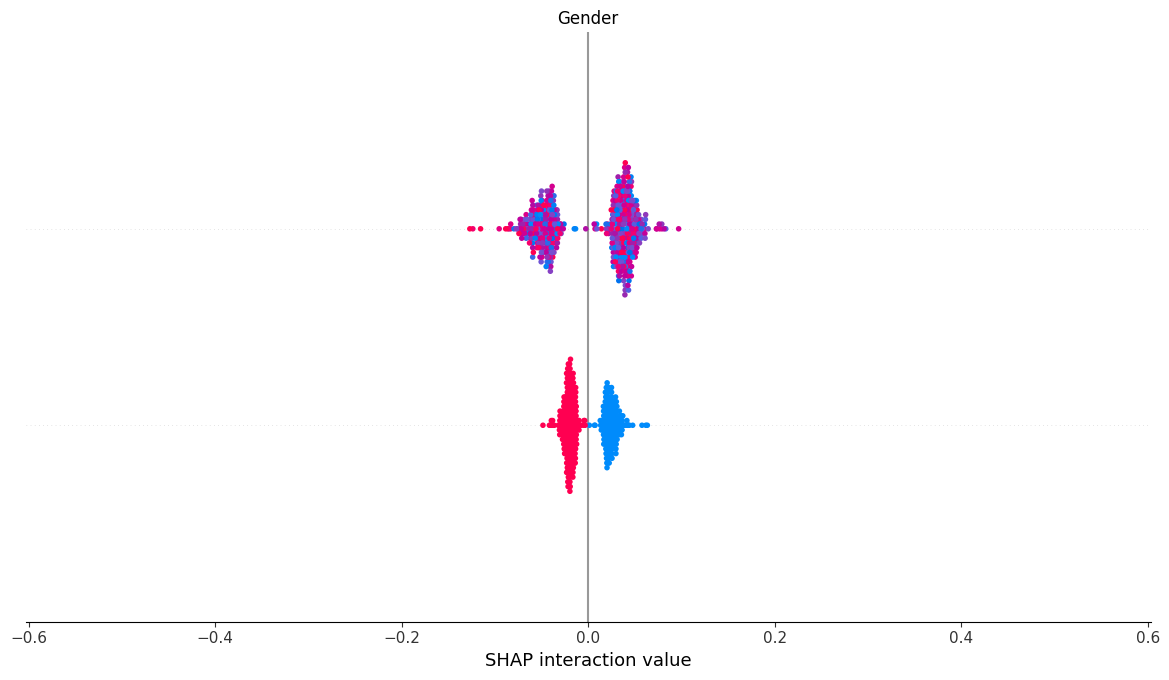

In [129]:
from sklearn.utils.random import sample_without_replacement

X_shap = X.iloc[sample_without_replacement(X.shape[0], 500, random_state=24), :]

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_shap)
print("X shape :", X.shape)
print("shap_values[1] shape :", shap_values.shape)   
shap.summary_plot(shap_values, X_shap, plot_type='bar', plot_size=0.4)
